In [34]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

RESUTLS_FOLDER_PATH = "../results/new_results/"
MIN_LENGTH = 100
MIN_MATCHES = 5

results_folders = [f for f in os.listdir(RESUTLS_FOLDER_PATH) if os.path.isdir(os.path.join(RESUTLS_FOLDER_PATH, f))]

results = []
for result_folder in results_folders:
    result = {}
    fields = result_folder.split("_")
    result['player_lv'] = 5 # fields[3]
    result['player_know'] = 5 # fields[4]
    result['defense_path'] = os.path.join(RESUTLS_FOLDER_PATH, result_folder, "defense_results.csv")
    result['offense_path'] = os.path.join(RESUTLS_FOLDER_PATH, result_folder, "offense_results.csv")
    result['rounds_path'] = os.path.join(RESUTLS_FOLDER_PATH, result_folder, "round_results.csv")
    if not os.path.exists(result['defense_path']) or not os.path.exists(result['offense_path']) or not os.path.exists(result['rounds_path']):
        continue

    results.append(result)
    
# results = [r for r in results if len(pd.read_csv(r['defense_path'])) >= MIN_LENGTH and len(pd.read_csv(r['offense_path'])) >= MIN_LENGTH]

print("Number of results before filtering:", len(results))
results_filtered = []
for result in results:
    rounds_df = pd.read_csv(result['rounds_path'])
    
    ai_wins = len(rounds_df[rounds_df['winner'] == "ai"])
    player_wins = len(rounds_df[rounds_df['winner'] == "player"])

    if (ai_wins >= MIN_MATCHES or player_wins >= MIN_MATCHES) and len(pd.read_csv(result['offense_path']).drop_duplicates()) >= MIN_LENGTH:
        results_filtered.append(result)

print("Number of results:", len(results_filtered))

print("Average, max, and median offense actions:")
offense_actions = []
for result in results_filtered:
    offense_df = pd.read_csv(result['offense_path']).drop_duplicates()
    offense_actions.append(len(offense_df))
print("Average:", np.mean(offense_actions))
print("Max:", np.max(offense_actions))
print("Min:", np.min(offense_actions))
print("Max csv path: ", results_filtered[np.argmax(offense_actions)]['offense_path'])
print("Median:", np.median(offense_actions))

for result in results_filtered:
    print(result)

Number of results before filtering: 1
Number of results: 1
Average, max, and median offense actions:
Average: 136.0
Max: 136
Min: 136
Max csv path:  ../results/new_results/richarlison/offense_results.csv
Median: 136.0
{'player_lv': 5, 'player_know': 5, 'defense_path': '../results/new_results/richarlison/defense_results.csv', 'offense_path': '../results/new_results/richarlison/offense_results.csv', 'rounds_path': '../results/new_results/richarlison/round_results.csv'}


In [35]:
defense_moves = ['Block', 'Guard_jump', 'Button', 'Throw', 'Reversal', 'Parry_high', 'Parry_low']
offense_moves = ['Throw', 'Delayed_tc', 'Meaty_high', 'Meaty_low', 'Shimmy_lp']

rvr_values = [
    [1, 0, 1, 0, -1.4, 1, 1],
    [0, 3.5, -3.5, -1, 3, -3.5, 3.5],
    [0, 0, 3.5, 3.5, -1.4, -3.5, 3.5],
    [0, 0, 2.5, 2.5, -1.4, 2.5, -3.5],
    [0, 0, -3, 3, 3.5, 0, 0]
]
  

AI Victories (Attack): [1.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16666666666666666, 0.14285714285714285, 0.125, 0.2222222222222222, 0.2, 0.18181818181818182, 0.25, 0.23076923076923078, 0.21428571428571427, 0.2, 0.1875, 0.23529411764705882, 0.2777777777777778, 0.3157894736842105, 0.3, 0.2857142857142857, 0.2727272727272727, 0.2608695652173913, 0.25, 0.24, 0.2692307692307692, 0.25925925925925924, 0.25, 0.27586206896551724, 0.3, 0.2903225806451613, 0.28125, 0.30303030303030304, 0.29411764705882354, 0.2857142857142857, 0.2777777777777778, 0.2972972972972973, 0.2894736842105263, 0.28205128205128205, 0.275, 0.2682926829268293, 0.2619047619047619, 0.2558139534883721, 0.2727272727272727, 0.26666666666666666, 0.2608695652173913, 0.2553191489361702, 0.2708333333333333, 0.2653061224489796, 0.28, 0.29411764705882354, 0.3076923076923077, 0.3018867924528302, 0.3148148148148148, 0.32727272727272727, 0.32142857142857145, 0.3157894736842105, 0.3275862068965517, 0.3220338983050847, 0.31666666666666665

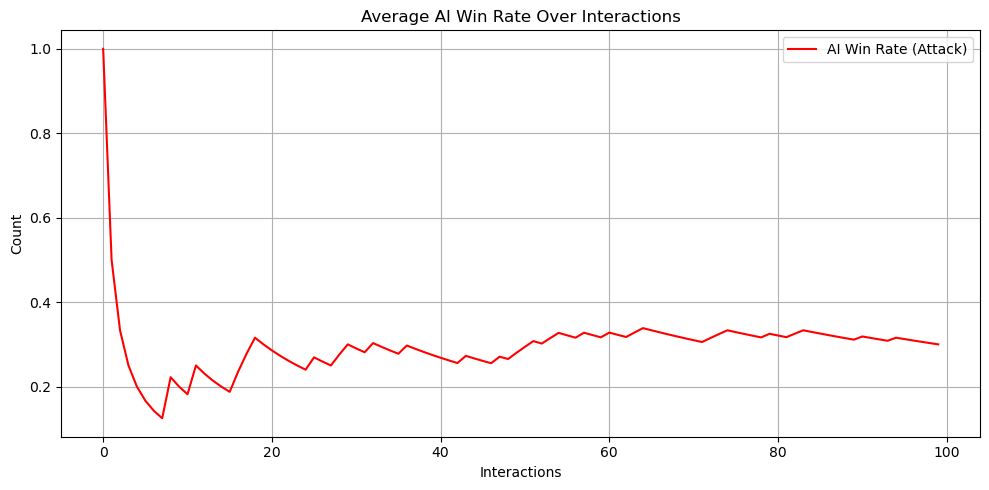

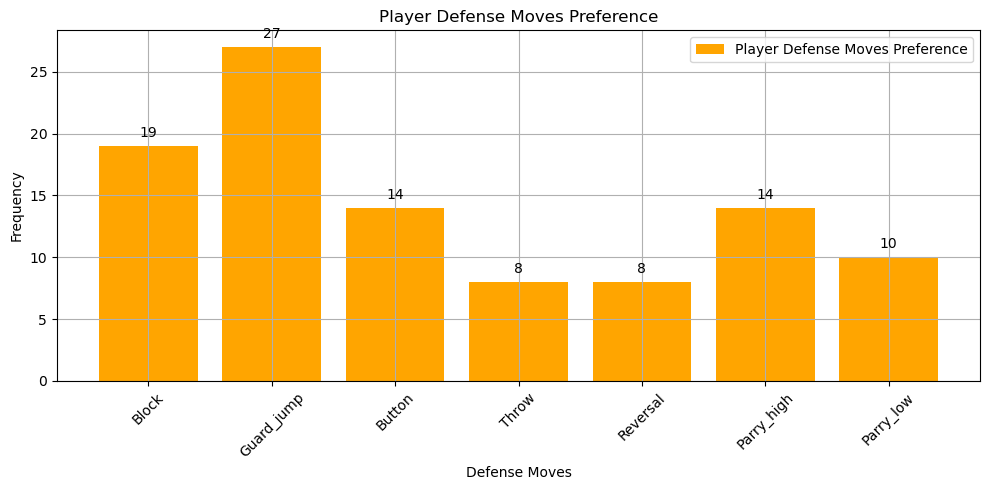

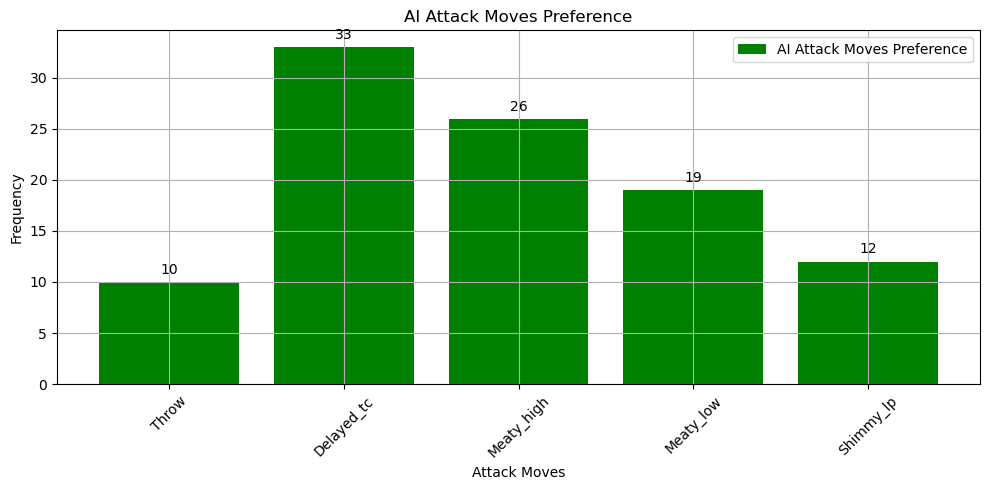

In [36]:
from ast import literal_eval

avg_ai_win_rate_def = [0] * MIN_LENGTH
ai_correct_pred = [0] * MIN_LENGTH

ai_def_moves_pref = {'Block' : 0, 'Guard_jump' : 0, 'Button' : 0, 'Throw' : 0,
                        'Reversal' : 0, 'Parry_high' : 0, 'Parry_low' : 0}
player_atk_moves_pref = {'Throw' : 0, 'Delayed_tc' : 0, 'Meaty_high' : 0,
                    'Meaty_low' : 0, 'Shimmy_lp' : 0}

for result in results_filtered:

    df_off = pd.read_csv(result['defense_path']).drop_duplicates()
    df_off = df_off.drop(df_off.index[0])
    df_off = df_off.dropna()
    df_off = df_off[:MIN_LENGTH]

    ai_defense = df_off['ai_offense']
    ai_pred_player_action = df_off['pred_defense']
    player_action = df_off['player_action']

    ai_defense_parsed = [literal_eval(x[x.find("(")+1:x.rfind(")")]) for x in ai_defense]
    ai_defense_parsed = [sorted(moves, key=lambda x: x[1], reverse=True) for moves in ai_defense_parsed]

    ai_pred_player_action_parsed = [literal_eval(x) for x in ai_pred_player_action]
    ai_pred_player_action_parsed = [sorted(moves, key=lambda x: x[1], reverse=True) for moves in ai_pred_player_action_parsed]
    
    total_ai_wins = 0
    ai_win_rate_atk = [0] * MIN_LENGTH
    for i, (ai_defense, player_action) in enumerate(zip(ai_defense_parsed, player_action)):
        ai_idx = offense_moves.index(ai_defense[0][0])
        pl_idx = defense_moves.index(player_action)
        rvr = rvr_values[ai_idx][pl_idx]

        if rvr_values[ai_idx][pl_idx] > 0:
            total_ai_wins += 1

        if player_action in [action[0] for action in ai_pred_player_action_parsed[i][:4]]:
            ai_correct_pred[i] += 1

        ai_def_moves_pref[player_action] += 1
        player_atk_moves_pref[ai_defense[0][0]] += 1
        ai_win_rate_atk[i] = total_ai_wins / (i + 1)

    # print(f"Processed defense results for {result['player_lv']} {result['player_know']}")
    avg_ai_win_rate_def = [x + y for x, y in zip(avg_ai_win_rate_def, ai_win_rate_atk)]

    # plot AI win rate over rounds
    # plt.figure(figsize=(10, 5))
    # plt.plot(ai_win_rate_atk, label=f"AI Win Rate {result['player_lv']} {result['player_know']}")
    # plt.xlabel('Interactions')
    # plt.ylabel('Win Rate')
    # plt.title(f"AI Win Rate Over Interactions for {result['player_lv']} {result['player_know']}")
    # plt.legend()
    # plt.grid()
    # plt.tight_layout()
    # plt.show()


avg_ai_win_rate_def = [x / len(results_filtered) for x in avg_ai_win_rate_def]

print("AI Victories (Attack):", avg_ai_win_rate_def)
print("AI Win Rate (Attack):", ai_win_rate_atk)

# # Plotting the results (AI wins and correct predictions)
plt.figure(figsize=(10, 5))
plt.plot(avg_ai_win_rate_def, label='AI Win Rate (Attack)', color='red')
# plt.plot(ai_correct_pred_rate, label='AI Correct Predictions rate', color='red')
plt.xlabel('Interactions')
plt.ylabel('Count')
plt.title('Average AI Win Rate Over Interactions')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Plot move preferences
plt.figure(figsize=(10, 5))
plt.bar(ai_def_moves_pref.keys(), ai_def_moves_pref.values(), label='Player Defense Moves Preference', color='orange')
plt.xlabel('Defense Moves')
plt.ylabel('Frequency')
plt.title('Player Defense Moves Preference')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
for i, v in enumerate(ai_def_moves_pref.values()):
    plt.text(i, v + 0.5, str(v), ha='center', va='bottom')
plt.show()

plt.figure(figsize=(10, 5))
plt.bar(player_atk_moves_pref.keys(), player_atk_moves_pref.values(), label='AI Attack Moves Preference', color='green')
plt.xlabel('Attack Moves')
plt.ylabel('Frequency')
plt.title('AI Attack Moves Preference')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
for i, v in enumerate(player_atk_moves_pref.values()):
    plt.text(i, v + 0.5, str(v), ha='center', va='bottom')
plt.show()

AI Victories (Defense): [0.0, 0.0, 0.0, 0.25, 0.4, 0.3333333333333333, 0.42857142857142855, 0.375, 0.4444444444444444, 0.4, 0.45454545454545453, 0.4166666666666667, 0.38461538461538464, 0.35714285714285715, 0.3333333333333333, 0.3125, 0.29411764705882354, 0.2777777777777778, 0.2631578947368421, 0.25, 0.2857142857142857, 0.2727272727272727, 0.2608695652173913, 0.25, 0.24, 0.2692307692307692, 0.25925925925925924, 0.25, 0.2413793103448276, 0.23333333333333334, 0.22580645161290322, 0.21875, 0.24242424242424243, 0.23529411764705882, 0.22857142857142856, 0.2222222222222222, 0.24324324324324326, 0.23684210526315788, 0.23076923076923078, 0.25, 0.2682926829268293, 0.2619047619047619, 0.27906976744186046, 0.2727272727272727, 0.26666666666666666, 0.2826086956521739, 0.2765957446808511, 0.2916666666666667, 0.30612244897959184, 0.3, 0.3137254901960784, 0.3076923076923077, 0.3018867924528302, 0.2962962962962963, 0.3090909090909091, 0.30357142857142855, 0.3157894736842105, 0.3103448275862069, 0.32203

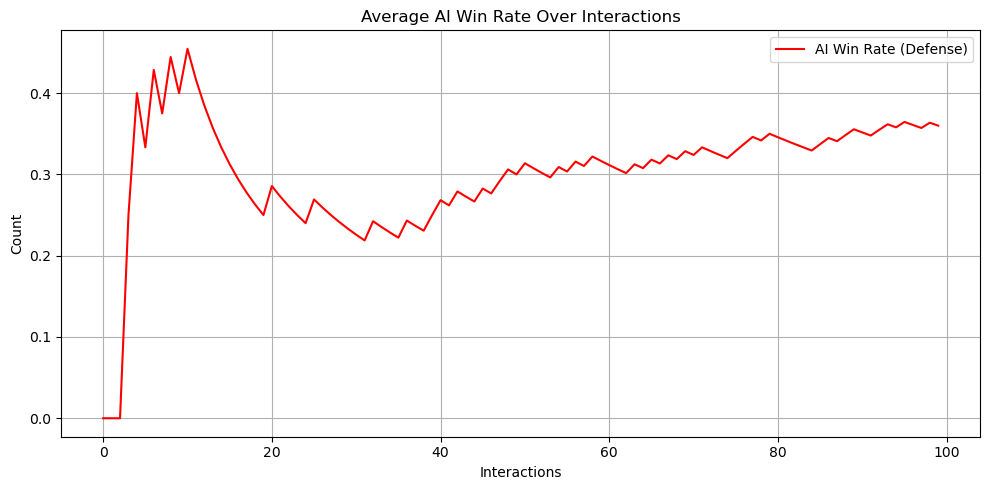

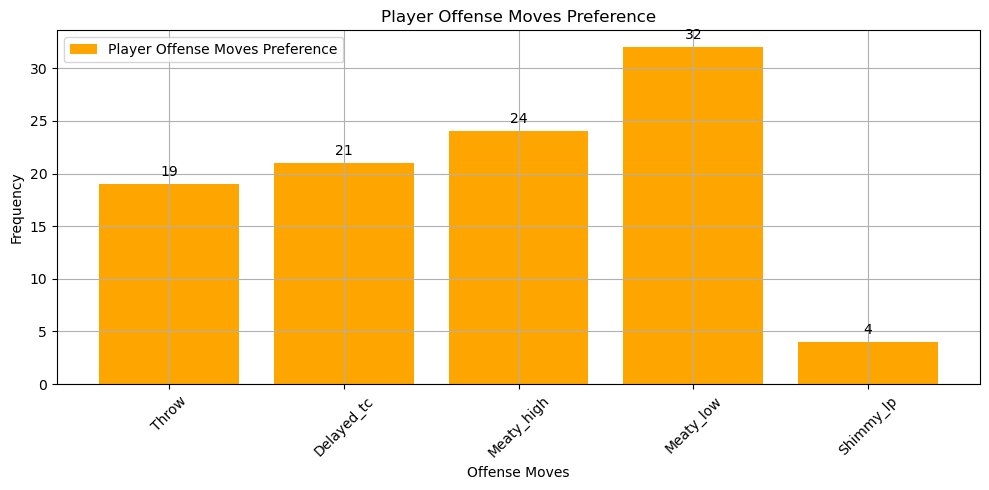

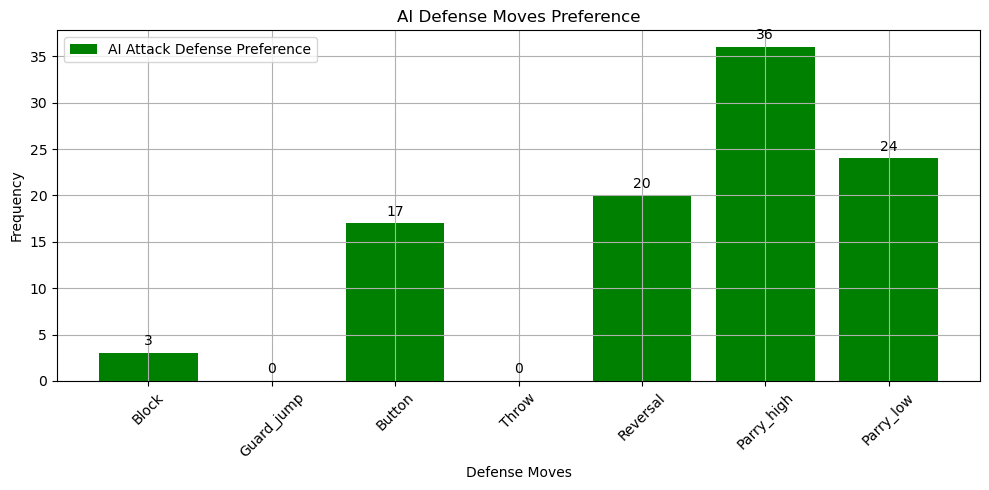

In [37]:
from ast import literal_eval

avg_ai_win_rate_def = [0] * MIN_LENGTH
ai_correct_pred = [0] * MIN_LENGTH

ai_def_moves_pref = {'Block' : 0, 'Guard_jump' : 0, 'Button' : 0, 'Throw' : 0,
                        'Reversal' : 0, 'Parry_high' : 0, 'Parry_low' : 0}
player_atk_moves_pref = {'Throw' : 0, 'Delayed_tc' : 0, 'Meaty_high' : 0,
                    'Meaty_low' : 0, 'Shimmy_lp' : 0}

for result in results_filtered:

    df_off = pd.read_csv(result['offense_path']).drop_duplicates()
    df_off = df_off.drop(df_off.index[0])
    df_off = df_off.dropna()
    df_off = df_off[:MIN_LENGTH]

    ai_defense = df_off['ai_defense']
    ai_pred_player_action = df_off['pred_offense']
    player_action = df_off['player_action']

    ai_defense_parsed = [literal_eval(x[x.find("(")+1:x.rfind(")")]) for x in ai_defense]
    ai_defense_parsed = [sorted(moves, key=lambda x: x[1], reverse=True) for moves in ai_defense_parsed]

    ai_pred_player_action_parsed = [literal_eval(x) for x in ai_pred_player_action]
    ai_pred_player_action_parsed = [sorted(moves, key=lambda x: x[1], reverse=True) for moves in ai_pred_player_action_parsed]
    
    total_ai_wins = 0
    ai_win_rate_atk = [0] * MIN_LENGTH
    for i, (ai_defense, player_action) in enumerate(zip(ai_defense_parsed, player_action)):
        ai_idx = defense_moves.index(ai_defense[0][0])
        pl_idx = offense_moves.index(player_action)
        rvr = rvr_values[pl_idx][ai_idx]

        if rvr < 0:
            total_ai_wins += 1

        if player_action in [action[0] for action in ai_pred_player_action_parsed[i][:4]]:
            ai_correct_pred[i] += 1

        ai_def_moves_pref[ai_defense[0][0]] += 1
        player_atk_moves_pref[player_action] += 1
        ai_win_rate_atk[i] = total_ai_wins / (i + 1)

    # print(f"Processed defense results for {result['player_lv']} {result['player_know']}")
    avg_ai_win_rate_def = [x + y for x, y in zip(avg_ai_win_rate_def, ai_win_rate_atk)]

    # plot AI win rate over rounds
    # plt.figure(figsize=(10, 5))
    # plt.plot(ai_win_rate_atk, label=f"AI Win Rate {result['player_lv']} {result['player_know']}")
    # plt.xlabel('Interactions')
    # plt.ylabel('Win Rate')
    # plt.title(f"AI Win Rate Over Interactions for {result['player_lv']} {result['player_know']}")
    # plt.legend()
    # plt.grid()
    # plt.tight_layout()
    # plt.show()


avg_ai_win_rate_def = [x / len(results_filtered) for x in avg_ai_win_rate_def]

print("AI Victories (Defense):", avg_ai_win_rate_def)
print("AI Win Rate (Defense):", ai_win_rate_atk)

# # Plotting the results (AI wins and correct predictions)
plt.figure(figsize=(10, 5))
plt.plot(avg_ai_win_rate_def, label='AI Win Rate (Defense)', color='red')
# plt.plot(ai_correct_pred_rate, label='AI Correct Predictions rate', color='red')
plt.xlabel('Interactions')
plt.ylabel('Count')
plt.title('Average AI Win Rate Over Interactions')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Plot move preferences
plt.figure(figsize=(10, 5))
plt.bar(player_atk_moves_pref.keys(), player_atk_moves_pref.values(), label='Player Offense Moves Preference', color='orange')
plt.xlabel('Offense Moves')
plt.ylabel('Frequency')
plt.title('Player Offense Moves Preference')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
for i, v in enumerate(player_atk_moves_pref.values()):
    plt.text(i, v + 0.5, str(v), ha='center', va='bottom')
plt.show()

plt.figure(figsize=(10, 5))
plt.bar(ai_def_moves_pref.keys(), ai_def_moves_pref.values(), label='AI Attack Defense Preference', color='green')
plt.xlabel('Defense Moves')
plt.ylabel('Frequency')
plt.title('AI Defense Moves Preference')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
for i, v in enumerate(ai_def_moves_pref.values()):
    plt.text(i, v + 0.5, str(v), ha='center', va='bottom')
plt.show()

1


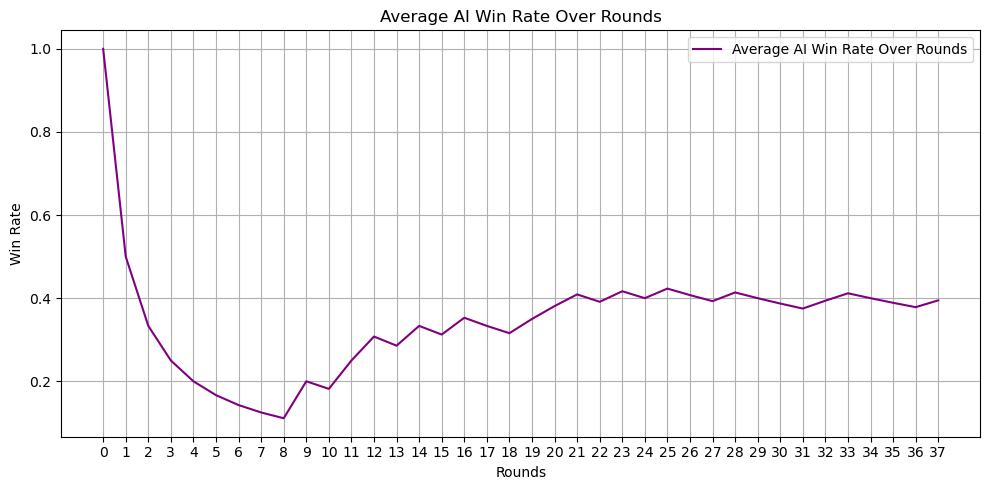

In [40]:
MIN_ROUNDS = 38

avg_ai_rounds_win_rate = [0] * MIN_ROUNDS
total_results = 0
for result in results_filtered:
    round_df = pd.read_csv(result['rounds_path'])
    if len(round_df) < MIN_ROUNDS:
        continue
    
    total_results += 1
    round_df = round_df[:MIN_ROUNDS]

    ai_win_rate = [0] * MIN_ROUNDS
    total_ai_wins = 0
    for i, winner in enumerate(round_df['winner']):
        if winner == "ai":
            total_ai_wins += 1
        ai_win_rate[i] = total_ai_wins / (i + 1)

    avg_ai_rounds_win_rate = [x + y for x, y in zip(avg_ai_rounds_win_rate, ai_win_rate)]

avg_ai_rounds_win_rate = [x / total_results for x in avg_ai_rounds_win_rate]

print(total_results)
plt.figure(figsize=(10, 5))
plt.plot(avg_ai_rounds_win_rate, label='Average AI Win Rate Over Rounds', color='purple')
plt.xlabel('Rounds')
plt.ylabel('Win Rate')
plt.title('Average AI Win Rate Over Rounds')
plt.legend()
plt.grid()
plt.tight_layout()
plt.xticks(range(MIN_ROUNDS))
plt.show()